# <span style="color:#e0bda8; font-size: 40px;">To Grant or Not to Grant</span>


# <span style="color:#e0bda8">0. Context</span>

The New York Workers’ Compensation Board (WCB) handles claims related to workplace injuries, a process that is often time-consuming when done manually. This project aims to develop a machine learning model to predict the "Claim Injury Type" based on historical claims data from 2020 to 2022. By automating this classification, we can help the WCB make quicker and more accurate decisions.

The project involves building and evaluating various multiclass classification models, optimizing their performance, and exploring key features that contribute to accurate predictions. Ultimately, the goal is to identify the best model that can efficiently assist in the decision-making process for new claims.


# <span style="color:#e0bda8">1. Import Packages and Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
import sqlite3
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler

# <span style="color:#e0bda8">2. Reading the Data</span>

In [2]:
df = pd.read_csv('resources/train_data.csv')
df

C:\Users\isabe\AppData\Local\Temp\ipykernel_18236\779365532.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('resources/train_data.csv')


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593467,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,...,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color:#e0bda8">3. Metadata</span>
- **Accident Date** - Injury date of the claim.
- **Age at Injury** - Age of injured worker when the injury occured.
- **Alternative Dispute Resolution** - Adjudication processes external to the Board.
- **Assembly Date** - The date the claim was first assembled.
- **Attorney/Representative** - Is the claim being represented by an Attorney?
- **Average Weekly Wage** - The wage used to calculate workers' compensation, disability, or an Paid Leave wage replacement benefits.
- **Birth Year** - The reported year of birth of the injured worker.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **Carrier Name** - Name of primary insurance provider responsible for providing workers' compensation coverage to the injured worker's employer.
- **Carrier Type** - Type of primary insurance provider responsible for providing workers' compensation coverage.
- **Claim Identifier** - Unique identifier for each claim, assigned by WCB.
- **Count of Injury** - Name of the New York County where the injury occured.
- **COVID-19 Indicator** - Indication that the claim may be associated with COVID-19.
- **District Name** - Name of the WCB district office that oversees claims for that region or area of the state.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.
- **Gender** - The reported gender of the injured worker.
- **IME-4 Count** - Number of IME-4 forms received per claim. The IME-4 form is the "Independent Examiner's Report of Independent Medical Examination" form.
- **Industry Code** - NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.
- **Industry Code Description** - 2-digit NAICS industry code description used to classify businesses according to their economic activity.
- **Medical Fee Region** - Approximate region where the injured worker would receive medical service.
- **OIICS Nature of Injury Description** - The OIICS nature of injury codes & descriptions are available at: https://www.bls.gov/iif/oiics_manual_2007.pdf.
- **WCIO Cause of Injury Code** - The WCIO cause of injury codes & descriptions are  at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.
- **WCIO Cause of Injury Description** - See description of field above.
- **WCIO Nature of Injury Code** - The WCIO nature of injury are available at
 https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.
- **WCIO Nature of Injury Description** - See description of field above.
- **WCIO Part Of Body Code** - The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.
- **WCIO Part Of Body Description** - See description of field above.
- **Zip Code** - The reported ZIP code of the injured worker’s home address.
- **Agreement Reached** - Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.
- **WCB Decision** - Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.
- **Claim Injury Type** - Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.

# <span style="color:#e0bda8">4. Dataset Overview</span>

## What are some characteristics of our data?

In [3]:
df.shape

(593471, 33)

In [4]:
df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [6]:
# Calculating the number of missing values
missing_values = df.isnull().sum()

# Adding percentage of missing values
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

sorted_missing_data.head(33)

,Missing Values,Percentage
OIICS Nature of Injury Description,593471,100.000000
IME-4 Count,460668,77.622664
First Hearing Date,442673,74.590502
C-3 Date,406226,68.449174
Birth Year,48523,8.176137
Average Weekly Wage,48096,8.104187
Zip Code,48082,8.101828
WCIO Part Of Body Description,36527,6.154808
WCIO Part Of Body Code,36527,6.154808
WCIO Nature of Injury Description,35102,5.914695


In [7]:
df[df.duplicated()]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


In [8]:
#Claim Identifier analysis
df[df["Claim Identifier"].duplicated() == True].T

,526445
Accident Date,NaN
Age at Injury,NaN
Alternative Dispute Resolution,NaN
Assembly Date,2022-09-05
Attorney/Representative,NaN
Average Weekly Wage,NaN
Birth Year,NaN
C-2 Date,NaN
C-3 Date,NaN
Carrier Name,NaN


In [9]:
df[df["Claim Identifier"]==292668076]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
257901,NaN,NaN,NaN,2021-05-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526445,NaN,NaN,NaN,2022-09-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial Data Insights

After importing the dataset and using the `info()` method, we gathered the following key insights:

### 1. Missing Values:
   Almost all columns in the dataset have missing values, except for:
- `Assembly Date`
- `Claim Identifier`

The variables **`OIICS Natue of Injury Description`**, **`IME-4 Count`**, **`First Hearing Date`** and **`C-3 Date`** have extremely high percentages of missing values (all above 65% of missing values). Particularly, the variable **`OIICS Nature of Injury Description`** has **100% missing values**, indicating that it is entirely missing across all entries in the dataset.

### 2. Potential Data Type Issues:
   - **Date Columns** (`Accident Date`, `Assembly Date`, `C-2 Date`, `C-3 Date`, `First Hearing Date`): These are currently stored as `object` types. They should be converted to `datetime` format for easier manipulation and analysis.
   - `Alternative Dispute Resolution`, `Attorney/Representative`, `COVID-19 INDICATOR`, `Agreement Reached`: These are likely binary variables but are stored as `object` or `float` types. Converting them to categorical or binary (`0` and `1`) might be more appropriate.
   - There are a lot of insconsistencies regarding data types, therefore further analysis should be performed in order to assure coherency.

### 3. Duplicates:
   There were no duplicates found.
    
These insights suggest that the dataset will require thorough preprocessing, including handling missing values and correcting data types to more suitable formats.

### 4. Claim Identifier as Potential Index:
 **Claim Identifier** contains a unique identifier for each claim, assigned by WCB, sugesting that it could potentially serve as the Index of the DataFrame. There was only one duplicate entry found, regarding **Claim Identifier 526445**, of which only two features did not contain NAs, further suporting this possibility.

## Data Type Analysis

- All categorical variables were assigned the data type category
- Date variables were assigned the data type datetime
- `Birth Year`,`Age at Injury`,`IME-4 Count` and `Number of Dependants` were converted from float to integer.

| Variable                           | Data Type | Change Data Type | New Data Type |
| ---------------------------------- | --------- | ---------------- | ------------- |
| Accident Date                      | object    | yes              | datetime      |
| Age at Injury                      | float     | yes              | int           |
| Alternative Dispute Resolution     | object    | yes              | category      |
| Assembly Date                      | object    | yes              | datetime      |
| Attorney/Representative            | object    | yes              | category      |
| Average Weekly Wage                | float     | no               |               |
| Birth Year                         | float     | yes              | int           |
| C-2 Date                           | object    | yes              | datetime      |
| C-3 Date                           | object    | yes              | datetime      |
| Carrier Name                       | object    | yes              | category      |
| Carrier Type                       | object    | yes              | category      |
| Claim Identifier                   | int       | yes              | category      |
| Claim Injury Type                  | object    | yes              | category      |
| County of Injury                   | object    | yes              | category      |
| COVID-19 Indicator                 | object    | yes              | category      |
| District Name                      | object    | yes              | category      |
| First Hearing Date                 | object    | yes              | datetime      |
| Gender                             | object    | yes              | category      |
| IME-4 Count                        | float     | yes              | int           |
| Industry Code                      | float     | yes              | category      |
| Industry Code Description          | object    | yes              | category      |
| Medical Fee Region                 | object    | yes              | category      |
| OIICS Nature of Injury Description | float     | no               |               |
| WCIO Cause of Injury Code          | float     | yes              | category      |
| WCIO Cause of Injury Description   | object    | yes              | category      |
| WCIO Nature of Injury Code         | float     | yes              | category      |
| WCIO Nature of Injury Description  | object    | yes              | category      |
| WCIO Part Of Body Code             | float     | yes              | category      |
| WCIO Part Of Body Description      | object    | yes              | category      |
| Zip Code                           | object    | yes              | category      |
| Agreement Reached                  | float     | yes              | category      |
| WCB Decision                       | object    | yes              | category      |
| Number of Dependents               | float     | yes              | int           |


## Binary Representation Conversion
Our dataset has 4 binary variables: `Alternative Dispute Resolution`, `Attorney/Representative`, `COVID-19 INDICATOR`, `Agreement Reached`, which we will now convert to the same notation. 

In [10]:
df['Alternative Dispute Resolution'].value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

In [11]:
# Convert Attorney/Representative to binary representation
df['Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].map({'Y': 1, 'N': 0, 'U':np.nan})

# Verify the conversion
df['Alternative Dispute Resolution'].unique()

array([ 0., nan,  1.])

In [12]:
df['Attorney/Representative'].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

In [13]:
# Convert Attorney/Representative to binary representation
df['Attorney/Representative'] = df['Attorney/Representative'].map({'Y': 1, 'N': 0})

# Verify the conversion
df['Attorney/Representative'].value_counts()

Attorney/Representative
0.0    392291
1.0    181735
Name: count, dtype: int64

In [14]:
df['COVID-19 Indicator'].value_counts()

COVID-19 Indicator
N    546505
Y     27521
Name: count, dtype: int64

In [15]:
# Convert COVID-19 Indicator to binary representation
df['COVID-19 Indicator'] = df['COVID-19 Indicator'].map({'Y': 1, 'N': 0})

# Verify the conversion
df['COVID-19 Indicator'].value_counts()

COVID-19 Indicator
0.0    546505
1.0     27521
Name: count, dtype: int64

In [16]:
#No need to change
df['Agreement Reached'].value_counts()

Agreement Reached
0.0    547239
1.0     26787
Name: count, dtype: int64

## Data Type Conversion

In [17]:
# Lists of variables by type
datetime_vars = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
category_vars = [
    'Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 
    'Carrier Type', 'Claim Identifier', 'Claim Injury Type', 'County of Injury', 
    'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Description', 
    'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 
    'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached', 
    'WCB Decision', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
    'WCIO Part Of Body Code', 'OIICS Nature of Injury Description', 'Medical Fee Region'
]
int_vars = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'Number of Dependents']

# Changing data types
df[datetime_vars] = df[datetime_vars].apply(pd.to_datetime, errors='coerce')  # Change to datetime
df[category_vars] = df[category_vars].astype('category')  # Change to category
df[int_vars] = df[int_vars].fillna(0).astype('int')  # Fill NaNs with 0 and change to int

# Display the updated DataFrame dtypes
print(df.dtypes)


Accident Date                         datetime64[ns]
Age at Injury                                  int32
Alternative Dispute Resolution              category
Assembly Date                         datetime64[ns]
Attorney/Representative                     category
Average Weekly Wage                          float64
Birth Year                                     int32
C-2 Date                              datetime64[ns]
C-3 Date                              datetime64[ns]
Carrier Name                                category
Carrier Type                                category
Claim Identifier                            category
Claim Injury Type                           category
County of Injury                            category
COVID-19 Indicator                          category
District Name                               category
First Hearing Date                    datetime64[ns]
Gender                                      category
IME-4 Count                                   

# <span style="color:#e0bda8">5. Univariate Analysis</span>

## Descriptive Statistics

In [18]:
df.describe(include = 'all').round(2).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Accident Date,570337,NaN,NaN,NaN,2021-04-28 21:00:27.892982784,1961-09-06 00:00:00,2020-09-14 00:00:00,2021-06-27 00:00:00,2022-03-21 00:00:00,2023-09-29 00:00:00,NaN
Age at Injury,593471.0,NaN,NaN,NaN,40.73,0.0,30.0,41.0,53.0,117.0,15.9
Alternative Dispute Resolution,574021.0,2.0,0.0,571412.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assembly Date,593471,NaN,NaN,NaN,2021-07-19 03:25:38.260841728,2020-01-01 00:00:00,2020-10-26 00:00:00,2021-07-29 00:00:00,2022-04-19 00:00:00,2022-12-31 00:00:00,NaN
Attorney/Representative,574026.0,2.0,0.0,392291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Weekly Wage,545375.0,NaN,NaN,NaN,491.09,0.0,0.0,0.0,841.0,2828079.0,6092.92
Birth Year,593471.0,NaN,NaN,NaN,1732.5,0.0,1962.0,1975.0,1988.0,2018.0,652.03
C-2 Date,559466,NaN,NaN,NaN,2021-07-16 20:11:19.865443328,1996-01-12 00:00:00,2020-11-06 00:00:00,2021-08-09 00:00:00,2022-04-26 00:00:00,2024-06-01 00:00:00,NaN
C-3 Date,187245,NaN,NaN,NaN,2021-07-26 21:31:28.449891840,1992-11-13 00:00:00,2020-10-27 00:00:00,2021-07-21 00:00:00,2022-04-20 00:00:00,2024-05-31 00:00:00,NaN
Carrier Name,574026,2046,STATE INSURANCE FUND,111144,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Variance

In [19]:
df.var(numeric_only=True)

Age at Injury           2.527947e+02
Average Weekly Wage     3.712365e+07
Birth Year              4.251372e+05
IME-4 Count             3.581932e+00
Number of Dependents    4.158512e+00
dtype: float64

## Insights from Variance Output of Numeric Variables

### 1. **High Variability in Key Variables**
- **Average Weekly Wage**: The variance of **37,123,650** suggests a significant disparity in wages among the claims. This indicates that while many claimants may earn a typical wage, there are outliers earning substantially higher amounts. This high variance could skew analyses related to compensation and benefits.
  
- **Claim Identifier**: With a variance of **1.164827e+16**, this suggests a large range of values. If this is truly an identifier, it should ideally have low variance, indicating a consistent format across entries. A high variance in claim identifiers may point to inconsistencies in data entry or generation processes.

### 2. **Moderate to Low Variability in Other Variables**
- **Age at Injury**: The variance of **203.25** indicates that most injured workers fall within a relatively similar age range, but with some variation. This could help identify demographic trends in workplace injuries.
  
- **IME-4 Count**: A variance of **8.02** suggests that the number of IME-4 forms received per claim does not vary widely, indicating that most claims are likely processed similarly in terms of medical evaluations.

- **Number of Dependents**: The variance of **4.00** shows some variability, suggesting that claims can vary in the number of dependents involved. This may affect benefit calculations and eligibility for support.

### 3. **Low Variance in Certain Injury Codes**
- **Industry Code**: The variance of **385.89** indicates diversity in industries but also suggests that many claims likely come from a core set of industries, which could be explored further in analysis.

- **WCIO Cause of Injury Code** and **WCIO Nature of Injury Code** have variances of **669.48** and **493.17**, respectively, suggesting a moderate amount of variability in the nature and causes of injuries, but still indicate some level of concentration in certain categories.

### 4. **Variable with No Variance**
- **OIICS Nature of Injury Description** has no entries (NaN), indicating a complete lack of data. This variable should either be addressed through data cleaning or removed from further analysis.

### 5. **Binary Variable Variance**
- **Agreement Reached** has a very low variance of **0.0445**, reflecting that the vast majority of claims do not result in an agreement without the involvement of WCB. This suggests that such outcomes are rare and may require special consideration in analyses.

## Recommendations
- **Investigate Outliers**: For variables with high variance, especially Average Weekly Wage, consider investigating outliers to determine if they represent legitimate data points or errors.
- **Data Validation**: Ensure that the Claim Identifier is being generated and recorded consistently across the dataset to prevent issues in further analyses.
- **Explore Demographics**: Utilize the Age at Injury variable to analyze trends related to age demographics in workplace injuries.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.

## Categorical vs Numerical Features
In this part of the univariate analysis we split the features in metric an non-metric features.

In [20]:
import pandas as pd

# Create empty lists to hold column names
numeric = []
categorical = []
categorical_non_high_cardinality = []

# Define a threshold for high cardinality
threshold = 25  

# Loop through the DataFrame columns to classify them
for column in df.columns:
    # Check if the column is a datetime type
    if pd.api.types.is_datetime64_any_dtype(df[column]):
        categorical.append(column)  # Treat datetime as categorical features
    elif isinstance(df[column].dtype, pd.CategoricalDtype) or df[column].dtype == 'object':
        categorical.append(column)  # Add to categorical features
        # Check for high cardinality
        if df[column].nunique() < threshold:
            categorical_non_high_cardinality.append(column)  # Add to non-high-cardinality categorical features
    else:
        numeric.append(column)  # Add to numeric features

# Convert lists to DataFrames
numeric_features = df[numeric]
categorical_features = df[categorical]
non_high_cardinality_features = df[categorical_non_high_cardinality]

# Get date features
date_features = categorical_features.filter(regex='Date')

# Output the results
print("Categorical features:\n", categorical, "\n")
print("Numerical features:\n", numeric, "\n")
print("Categorical non-high-cardinality features:\n", categorical_non_high_cardinality, "\n")

Categorical features:
 ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Identifier', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached', 'WCB Decision'] 

Numerical features:
 ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents'] 

Categorical non-high-cardinality features:
 ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Type', 'Claim Injury Type', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Desc

## Categorical Features Analysis

In [21]:
categorical_features.astype("category").describe().T

,count,unique,top,freq
Accident Date,570337,5539,2020-03-01 00:00:00,1245
Alternative Dispute Resolution,574021.0,2.0,0.0,571412.0
Assembly Date,593471,1096,2020-03-06 00:00:00,1422
Attorney/Representative,574026.0,2.0,0.0,392291.0
C-2 Date,559466,2475,2021-05-11 00:00:00,1847
C-3 Date,187245,1648,2021-04-21 00:00:00,350
Carrier Name,574026,2046,STATE INSURANCE FUND,111144
Carrier Type,574026,8,1A. PRIVATE,285368
Claim Identifier,593471,593470,292668076,2
Claim Injury Type,574026,8,2. NON-COMP,291078


In [22]:
# Calculating the number of missing values
missing_values = categorical_features.isnull().sum()

# Adding percentage of missing values
total_rows = len(categorical_features)
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

sorted_missing_data.head(33)

,Missing Values,Percentage
OIICS Nature of Injury Description,593471,100.000000
First Hearing Date,442673,74.590502
C-3 Date,406226,68.449174
Zip Code,48082,8.101828
WCIO Part Of Body Description,36527,6.154808
WCIO Part Of Body Code,36527,6.154808
WCIO Nature of Injury Description,35102,5.914695
WCIO Nature of Injury Code,35102,5.914695
WCIO Cause of Injury Description,35085,5.911831
WCIO Cause of Injury Code,35085,5.911831


In [23]:
categorical_features["WCIO Part Of Body Code"]

0         62.0
1         38.0
2         10.0
3          NaN
4         36.0
          ... 
593466     NaN
593467    -9.0
593468     NaN
593469     NaN
593470     NaN
Name: WCIO Part Of Body Code, Length: 593471, dtype: category
Categories (57, float64): [-9.0, 10.0, 11.0, 12.0, ..., 66.0, 90.0, 91.0, 99.0]

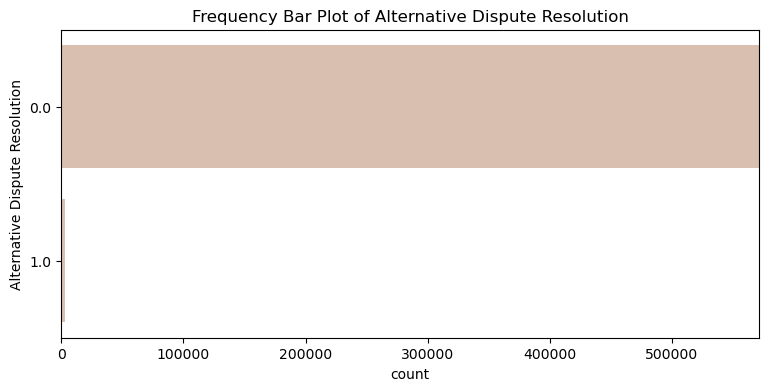

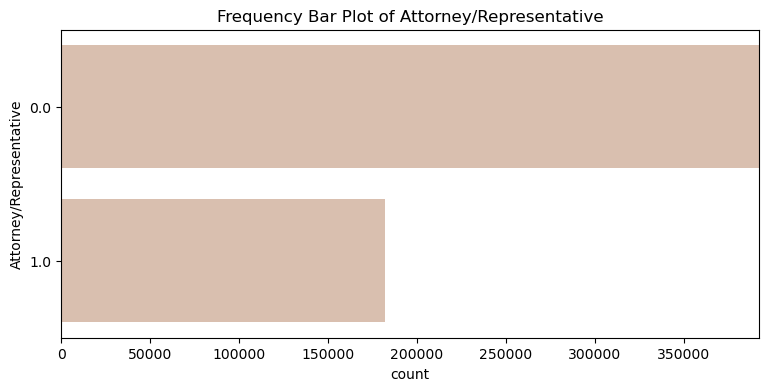

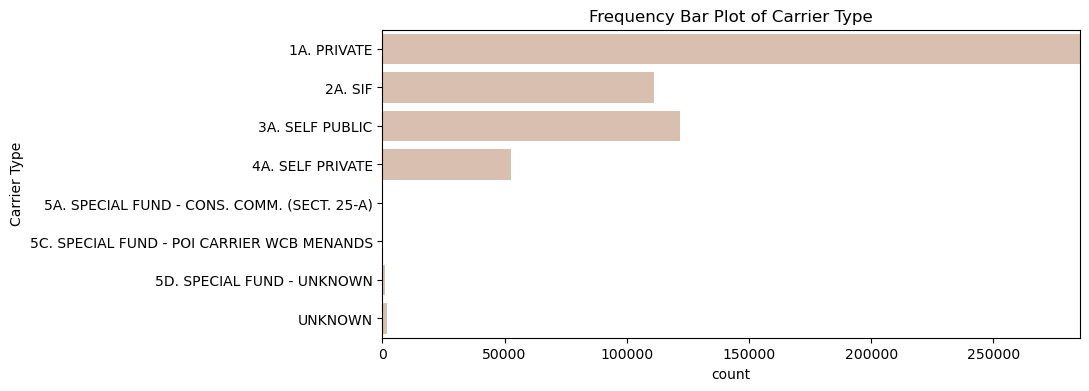

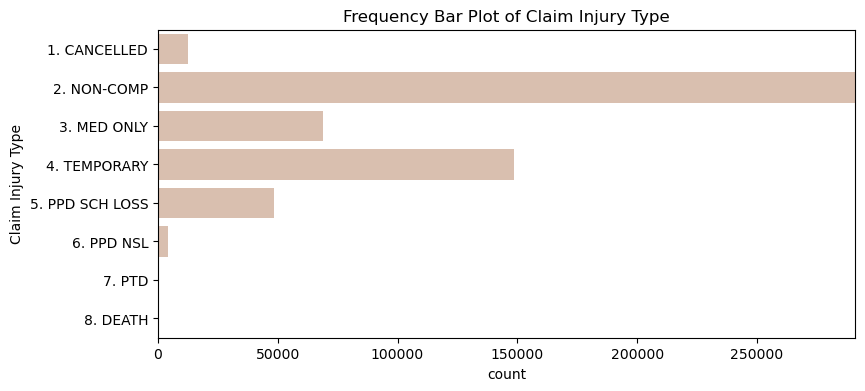

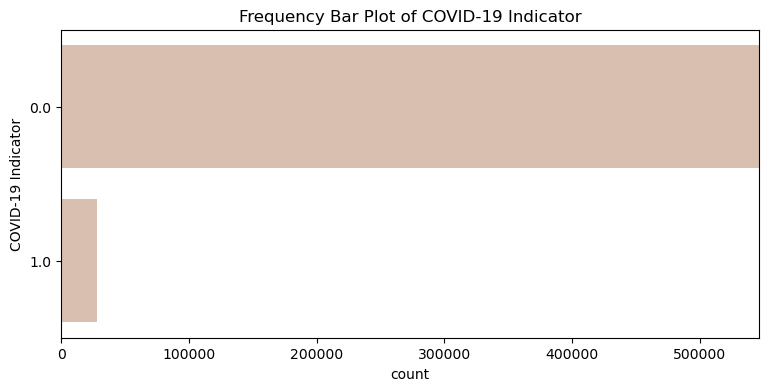

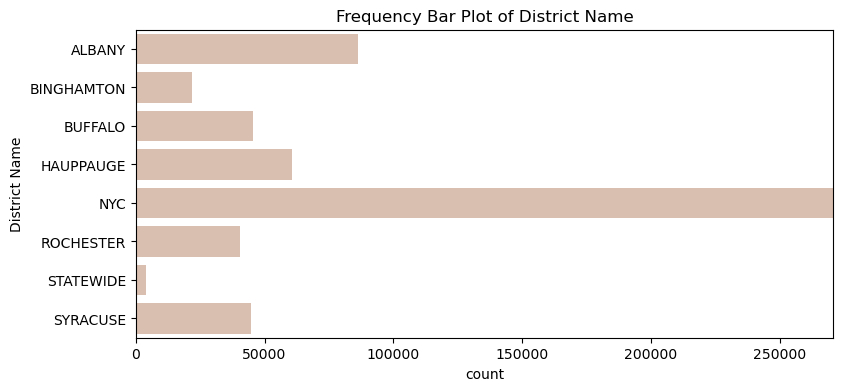

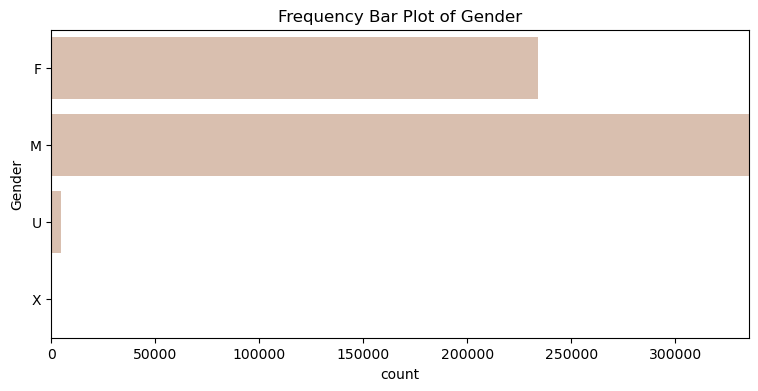

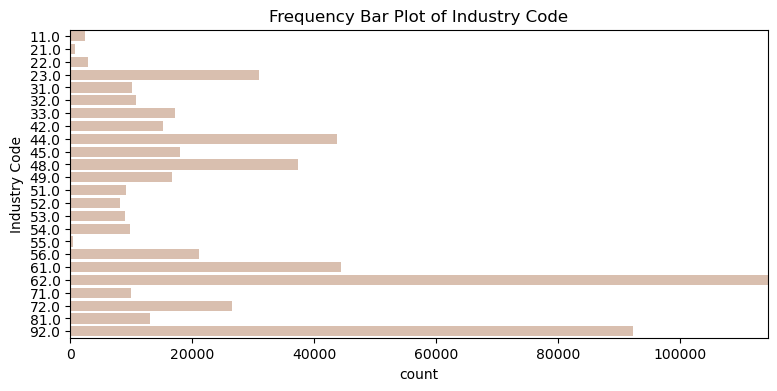

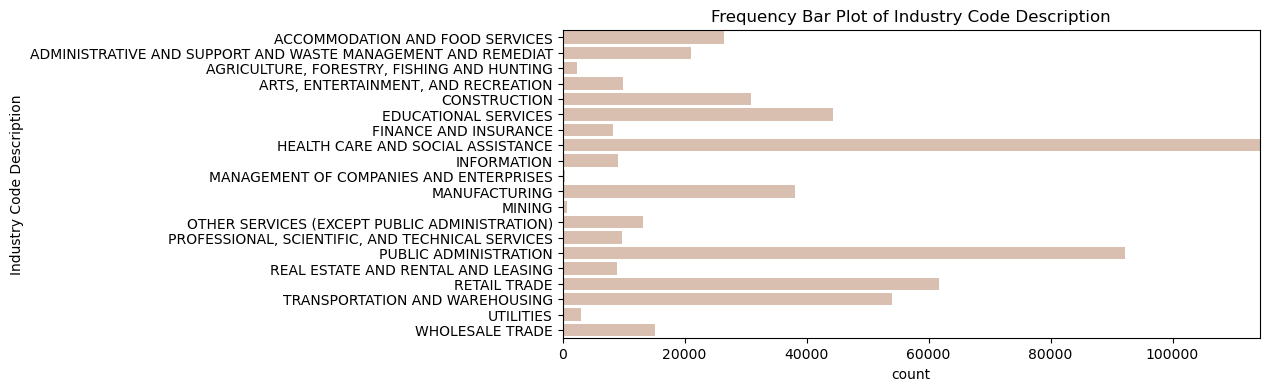

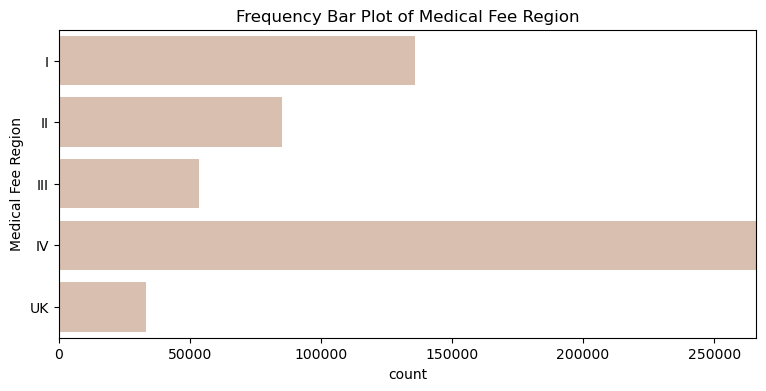

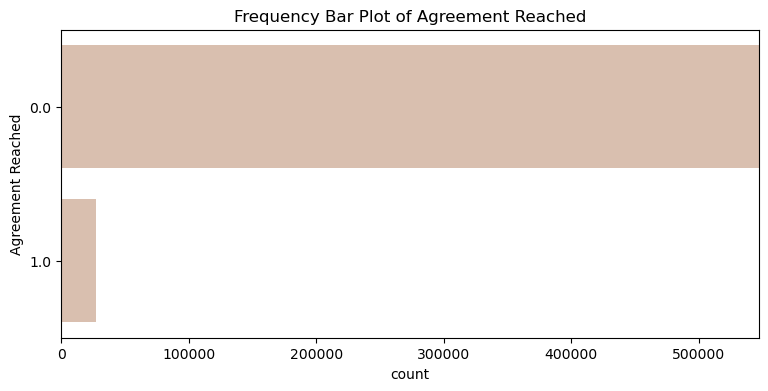

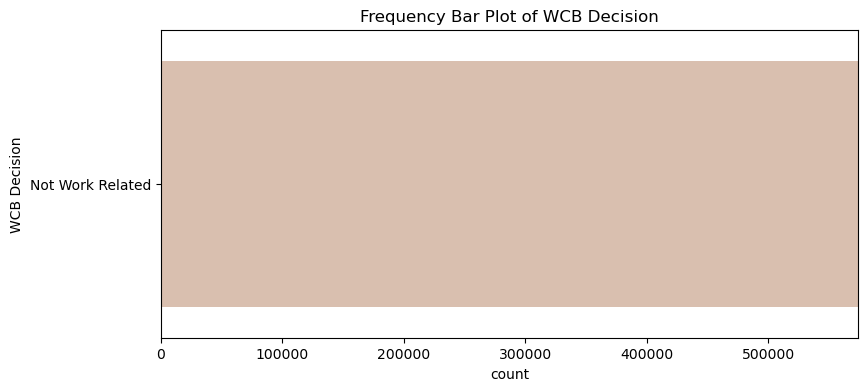

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through the non-high-cardinality categorical features
for var in non_high_cardinality_features.drop(columns=["OIICS Nature of Injury Description"]).columns:
    fig, ax = plt.subplots(figsize=(9, 4))

    # Create a horizontal count plot for categorical data
    sns.countplot(data=non_high_cardinality_features, y=var, ax=ax, color='#e0bda8')

    # Set title
    ax.set_title(f'Frequency Bar Plot of {var}')
    
    # Calculate counts for setting x-axis limit
    counts = non_high_cardinality_features[var].value_counts()

    # Set x-axis limit based on the counts
    if not counts.empty:
        ax.set_xlim(0, counts.max() + 1)  # Add a little space to the right of max count
    else:
        ax.set_xlim(0, 1)  # Set a default limit if no data is available

    # Show the plot
    plt.show()

## Insights from Categorical Features Analysis

### 1. Feature with 100% Missing Values
- The **OIICS Nature of Injury Description** column has no entries at all (`0.0 count`), indicating that this variable is entirely missing. This may require dropping the column from analysis or substituting it with an appropriate placeholder if needed.
  
### 2. High Cardinality in Categorical Variables
- As previously stated, many variables, such as **Carrier Name**, **County of Injury** and **Claim Identifier** have a large number of unique values (2046 and 63, respectively). While this is expected in datasets with various providers and geographical locations, it may complicate analysis and visualization, leading to potential overfitting in models if not handled properly.

### 3. Binary Variables with Low Variability
- **Agreement Reached** has a mean of **0.05**, indicating that only about 5% of claims result in an agreement without the involvement of WCB. This could signal a lack of diversity in outcomes.
- **COVID-19 Indicator** has a similar pattern, showing that the majority of claims do not appear to be related to COVID-19, which could skew insights if this factor is essential for analysis.

### 4. Unusual Values
- **Gender**: There are **4 unique values** for this column, which is unexpected if it typically only represents male and female. Investigating these unique values could be helpful.
- **WCB Decision**: The count indicates that every entry states “Not Work Related,” suggesting that this variable may not be functioning as expected, or it might require further investigation into why other categories are absent.
- **WCIO Part of Body Code**: There are negative values, which is unusual for a code.

## Recommendations
- **Data Validation**: For example, ensure that certain variables, such as the Claim Identifier, are being generated and recorded consistently across the dataset to prevent issues in further analyses.
- **Examine Unique Values**: Review categorical columns with unexpected unique counts to understand their implications on the analysis.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.

## Date Features Analysis

- **Accident Date** - Injury date of the claim.
- **Assembly Date** - The date the claim was first assembled.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.

In [25]:
date_features.describe().T

,count,mean,min,25%,50%,75%,max
Accident Date,570337,2021-04-28 21:00:27.892982784,1961-09-06 00:00:00,2020-09-14 00:00:00,2021-06-27 00:00:00,2022-03-21 00:00:00,2023-09-29 00:00:00
Assembly Date,593471,2021-07-19 03:25:38.260841728,2020-01-01 00:00:00,2020-10-26 00:00:00,2021-07-29 00:00:00,2022-04-19 00:00:00,2022-12-31 00:00:00
C-2 Date,559466,2021-07-16 20:11:19.865443328,1996-01-12 00:00:00,2020-11-06 00:00:00,2021-08-09 00:00:00,2022-04-26 00:00:00,2024-06-01 00:00:00
C-3 Date,187245,2021-07-26 21:31:28.449891840,1992-11-13 00:00:00,2020-10-27 00:00:00,2021-07-21 00:00:00,2022-04-20 00:00:00,2024-05-31 00:00:00
First Hearing Date,150798,2022-03-19 05:07:38.218278400,2020-01-30 00:00:00,2021-06-01 00:00:00,2022-03-09 00:00:00,2023-01-11 00:00:00,2024-06-07 00:00:00


#### Data Range Analysis

In [26]:
for col in ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']:
    min_date = df[col].min()
    max_date = df[col].max()
    print(f"{col} - Min Date: {min_date}, Max Date: {max_date}")

Accident Date - Min Date: 1961-09-06 00:00:00, Max Date: 2023-09-29 00:00:00
Assembly Date - Min Date: 2020-01-01 00:00:00, Max Date: 2022-12-31 00:00:00
C-2 Date - Min Date: 1996-01-12 00:00:00, Max Date: 2024-06-01 00:00:00
C-3 Date - Min Date: 1992-11-13 00:00:00, Max Date: 2024-05-31 00:00:00
First Hearing Date - Min Date: 2020-01-30 00:00:00, Max Date: 2024-06-07 00:00:00


#### Checking the chronological distribution of the other dates compraing to Accident Date

In [27]:
date_features2 = date_features.copy()

# Check if Accident Date is after the other dates using .loc
date_features2.loc[:, 'Accident After Assembly'] = date_features2['Accident Date'] > date_features2['Assembly Date']
date_features2.loc[:, 'Accident After C-2'] = date_features2['Accident Date'] > date_features2['C-2 Date']
date_features2.loc[:, 'Accident After C-3'] = date_features2['Accident Date'] > date_features2['C-3 Date']
date_features2.loc[:, 'Accident After First Hearing'] = date_features2['Accident Date'] > date_features2['First Hearing Date']

# Count unique combinations of the True/False values for each column
combination_counts = date_features2[['Accident After Assembly', 'Accident After C-2', 
                                     'Accident After C-3', 'Accident After First Hearing']].value_counts()

# Display the combination counts
print(combination_counts)

Accident After Assembly  Accident After C-2  Accident After C-3  Accident After First Hearing
False                    False               False               False                           591770
True                     True                True                False                              509
                         False               True                False                              493
                         True                False               False                              318
False                    False               True                False                              209
                         True                False               False                               77
True                     True                True                True                                66
                         False               False               False                               13
False                    True                True                False    

#### Time differences from Accident Date

In [28]:
# Calculate time differences
date_features2['Days to Assembly'] = (date_features2['Assembly Date'] - date_features2['Accident Date']).dt.days
date_features2['Days to C-2'] = (date_features2['C-2 Date'] - date_features2['Accident Date']).dt.days
date_features2['Days to C-3'] = (date_features2['C-3 Date'] - date_features2['Accident Date']).dt.days
date_features2['Days to First Hearing'] = (date_features2['First Hearing Date'] - date_features2['Accident Date']).dt.days

date_features2[['Days to Assembly', 'Days to C-2', 'Days to C-3', 'Days to First Hearing']].describe()

,Days to Assembly,Days to C-2,Days to C-3,Days to First Hearing
count,570337.000000,557346.00000,183798.000000,149347.000000
mean,82.227483,70.35153,97.444298,335.081984
std,603.986690,511.63367,406.096844,438.469419
min,-1127.000000,-8842.00000,-9870.000000,-576.000000
25%,5.000000,5.00000,12.000000,147.000000
50%,10.000000,10.00000,27.000000,237.000000
75%,24.000000,27.00000,71.000000,420.000000
max,21503.000000,21503.00000,18566.000000,16373.000000


#### Checking for patterns is missing values

In [29]:
# Check for missing dates in each column
missing_dates = date_features2[['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']].isna().sum()
print("Missing Dates Count:\n", missing_dates)

Missing Dates Count:
 Accident Date          23134
Assembly Date              0
C-2 Date               34005
C-3 Date              406226
First Hearing Date    442673
dtype: int64


In [30]:
# Calculating the number of missing values
missing_values = date_features.isnull().sum()

# Adding percentage of missing values
total_rows = date_features.shape[0]
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

sorted_missing_data.head()

,Missing Values,Percentage
First Hearing Date,442673,74.590502
C-3 Date,406226,68.449174
C-2 Date,34005,5.729850
Accident Date,23134,3.898084
Assembly Date,0,0.000000


#### Checking if all dates are valid dates

In [31]:
# List of date columns to check
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

# Initialize an empty list to store invalid date information
invalid_dates_list = []

# Loop through each date column to check for invalid dates
for col in date_columns:
    # Check for invalid dates that are not NaT
    for index, date_value in date_features[col].items():
        if pd.notna(date_value):  # Only consider non-NaT values
            if not isinstance(date_value, pd.Timestamp):  # Check if it is not a valid Timestamp
                invalid_dates_list.append({
                    'Index': index,
                    'Date Column': col,
                    'Invalid Date': date_value
                })

# Convert list of invalid dates to a DataFrame
if invalid_dates_list:
    invalid_dates_df = pd.DataFrame(invalid_dates_list)
    print("Invalid dates found:")
    display(invalid_dates_df)
else:
    print("All dates are valid.")

All dates are valid.


## Insights from Date Features Analysis

### 1. Date Range
- The earliest date entry is **`Accident Date`** **2021-04-28** and the most recent date entry is **`C-2 Date`** **2024-05-31**.

### 2. Data Incoherencies
- In 99.7% of cases, the Accident Date happens before all the other dates. However, there still are several instances where that isn't the case.
- The most recent **`C-2 Date`** date entry is from 2024, while the date entries from all the other date variables are all from 2022, which may suggest an error.

### 3. Missing Values
- **`Assembly Date`** has no missing values. However, all the other date variables have missing values.
-  **`First Hearing Date`** and **`C-3 Date`** have, respectively, 75% and 68% of missing values, indicating that not all claims have received this follow-up, which may impact analysis regarding claims processing times.

### 4. Variability in Date Columns
- Both **Accident Date** and **Assembly Date** have high unique counts (5539 and 1096, respectively), indicating diverse dates, but the frequency of specific dates (like `2020-03-01` for Accident Date) could suggest clustering or common reporting patterns.

## Recommendations
- **Validate Date Entries**: Confirm that all dates are within a logical range (e.g., Accident Date is always before other date fields). If this is not the case, further investigate, replace or remove such entries.
- **Handle Missing Values**: Use the appropriate methods to fill missing values for First Hearing Date and C-3 Date. Might be worth it to look into Indicator Variables, that is, creating binary columns indicating whether a date is missing (1) or present (0) to help analyze the impact of missing data.
- **Outlier Handling**: Outliers should be investigated to determine if they are legitimate data points or errors. Use methods such as IQR or z-scores to identify and potentially treat outliers in numerical columns.

## Numeric Features Analysis

In [32]:
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,593471.0,40.734402,15.899520,0.0,30.0,41.0,53.0,117.0
Average Weekly Wage,545375.0,491.088321,6092.918120,0.0,0.0,0.0,841.0,2828079.0
Birth Year,593471.0,1732.502906,652.025483,0.0,1962.0,1975.0,1988.0,2018.0
IME-4 Count,593471.0,0.717717,1.892599,0.0,0.0,0.0,0.0,73.0
Number of Dependents,593471.0,2.908049,2.039243,0.0,1.0,3.0,5.0,6.0


In [33]:
# Calculating the number of missing values
missing_values = numeric_features.isnull().sum()

# Adding percentage of missing values
total_rows = len(numeric_features)
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

sorted_missing_data.head(33)

,Missing Values,Percentage
Average Weekly Wage,48096,8.104187
Age at Injury,0,0.000000
Birth Year,0,0.000000
IME-4 Count,0,0.000000
Number of Dependents,0,0.000000


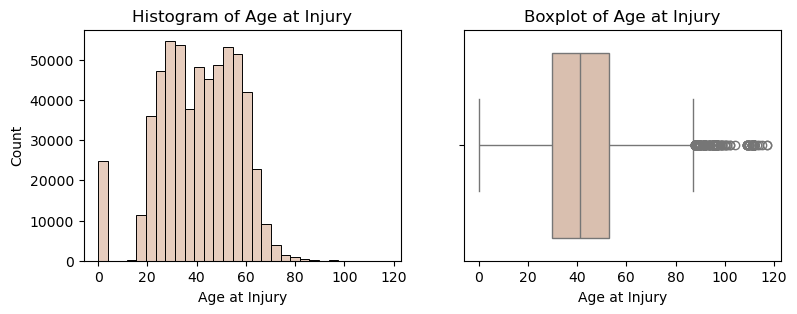

Skew: -0.37618163431607793, Kurtosis : 0.046668136284776285


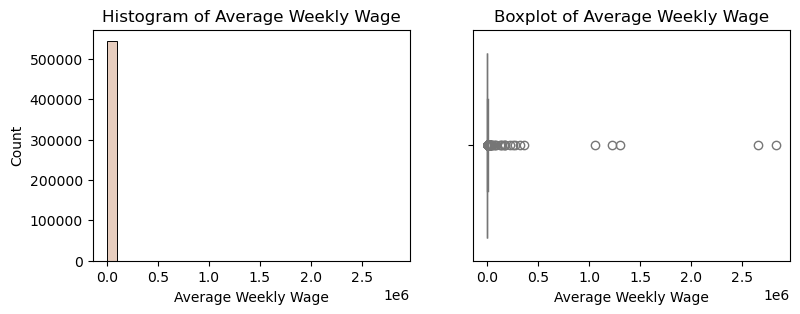

Skew: 378.97927206721073, Kurtosis : 160021.03948371377


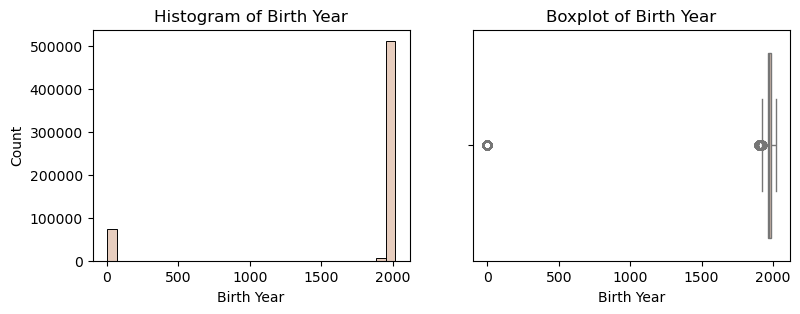

Skew: -2.279573822283096, Kurtosis : 3.2000866526831766


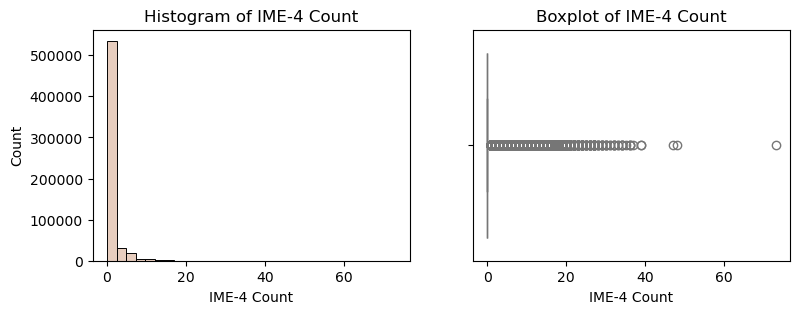

Skew: 4.39064590048189, Kurtosis : 31.325357982511555


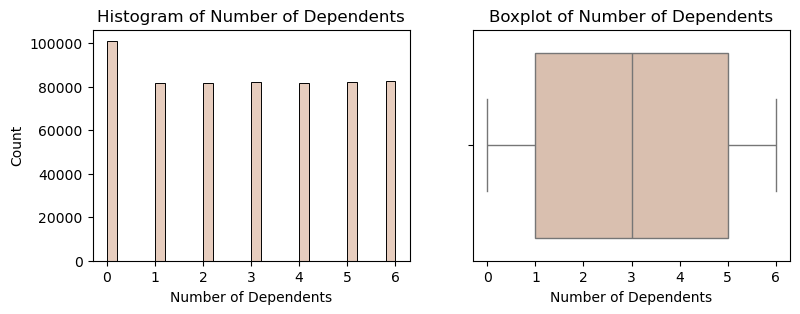

Skew: 0.03680388139163517, Kurtosis : -1.2837792570516349


In [34]:
for var in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

    #create histogram
    sns.histplot(ax=ax1, x=numeric_features[var], bins=30, color='#e0bda8')
    ax1.set_title(f"Histogram of {var}")

    #create boxplot
    sns.boxplot(ax=ax2, x=numeric_features[var], color='#e0bda8')
    ax2.set_title(f"Boxplot of {var}")

    plt.show()
    
    # Print skewness and kurtosis
    print(f'Skew: {numeric_features[var].skew()}, Kurtosis : {numeric_features[var].kurt()}')


In [35]:
numeric_features_copy = numeric_features.copy()

# Function to identify outliers based on IQR
def identify_outliers_iqr(df):
    outliers_dict = {}
    
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):  # Check if the column is numeric
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identify outliers
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            outliers_dict[column] = outliers
            
    return outliers_dict

# Identify outliers in the numeric features DataFrame
outliers_found = identify_outliers_iqr(numeric_features_copy)

# Display the number of outliers found for each numeric feature
print("Number of outliers in each numeric feature:")
for column, outliers in outliers_found.items():
    print(f"{column}: {len(outliers)} outliers")

Number of outliers in each numeric feature:
Age at Injury: 220 outliers
Average Weekly Wage: 22257 outliers
Birth Year: 73763 outliers
IME-4 Count: 132803 outliers
Number of Dependents: 0 outliers


## Insights from Numeric Features Analysis

### 1. Extreme Values in Numerical Columns
- **Average Weekly Wage**: The maximum value is **2,828,079**, which seems unusually high compared to the mean of **491.09**. This may indicate outliers or data entry errors.
- **Claim Identifier**: The mean is very high at **23,667,598.79** with a maximum value of **999,891,667.0**, which could suggest an issue with how these identifiers are generated or logged. This high variability may require further examination.

### 2. Data Incoherencies
- **Birth Year**: The mean birth year is 1732, with a minimum of 0 and a maximum of 2018. This appears anomalous, suggesting potential errors in the data entry for birth years.
- **Age at Injury**: Age at injuty has a range from 0 to 117 years, suggesting errors.

### 3. Missing Values
- **Average Weekly Wage**: Average Weekly Wage has 48096 missing values, which account for 8% of the data, suggesting they should ne handled. No other numeric variables have missing values.

### 4. Outliers
- All numeric variables, except for `Number of Dependants`, contain a large amount of outliers. 

## Recommendations
- **Data Cleaning**: Consider dropping or filling in missing values for entirely missing columns.
- **Analyze Relationships**: For example: Investigate relationships between Age, Weekly Wage, and Number of Dependents (it may be interesting to see if younger individuals tend to have lower wages or fewer dependents); Investigate the relatioship between Birth Year and Age at Injury (could we drop one?)
- **Outlier Handling**: Outliers should be investigated to determine if they are legitimate data points or errors. Use methods such as IQR or z-scores to identify and potentially treat outliers in numerical columns.

# <span style="color:#e0bda8">6. Bivariate Analysis</span>

## Pairwise Relatioship for Numerical Variables with Target Variable

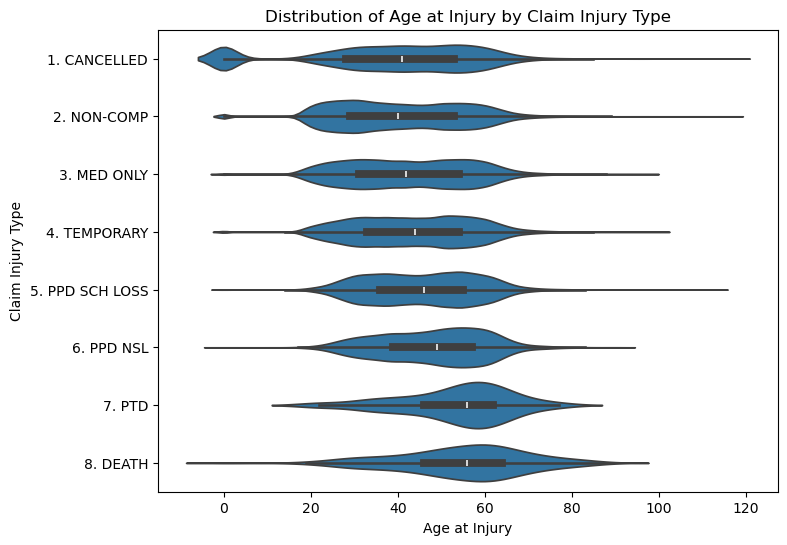

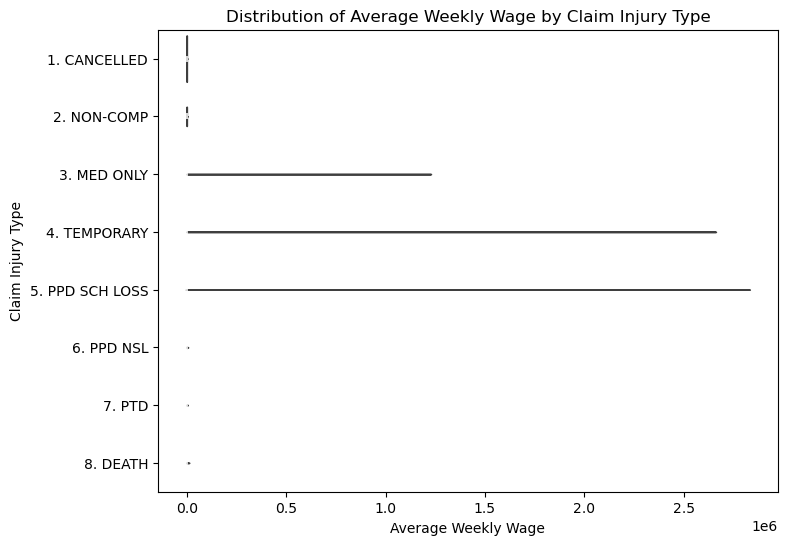

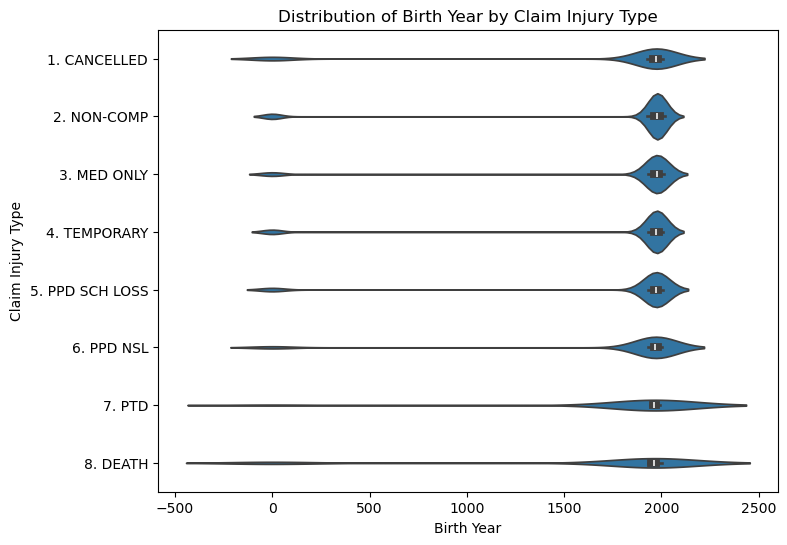

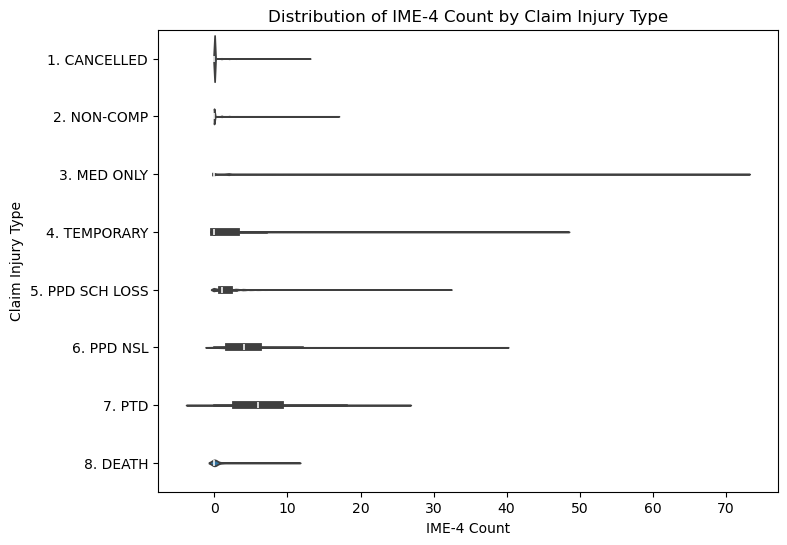

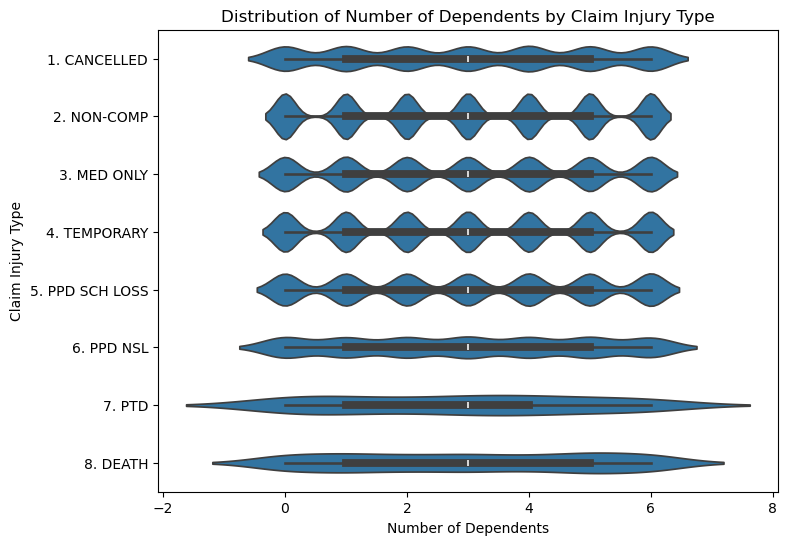

In [36]:
target_variable = 'Claim Injury Type' 
# Iterate over numeric features and create violin plots
for feature in numeric:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=feature, y=target_variable, data=df)
    plt.xlabel(feature)
    plt.ylabel(target_variable)
    plt.title(f"Distribution of {feature} by {target_variable}")
    plt.show()


## Correlation Matrix Numeric Features

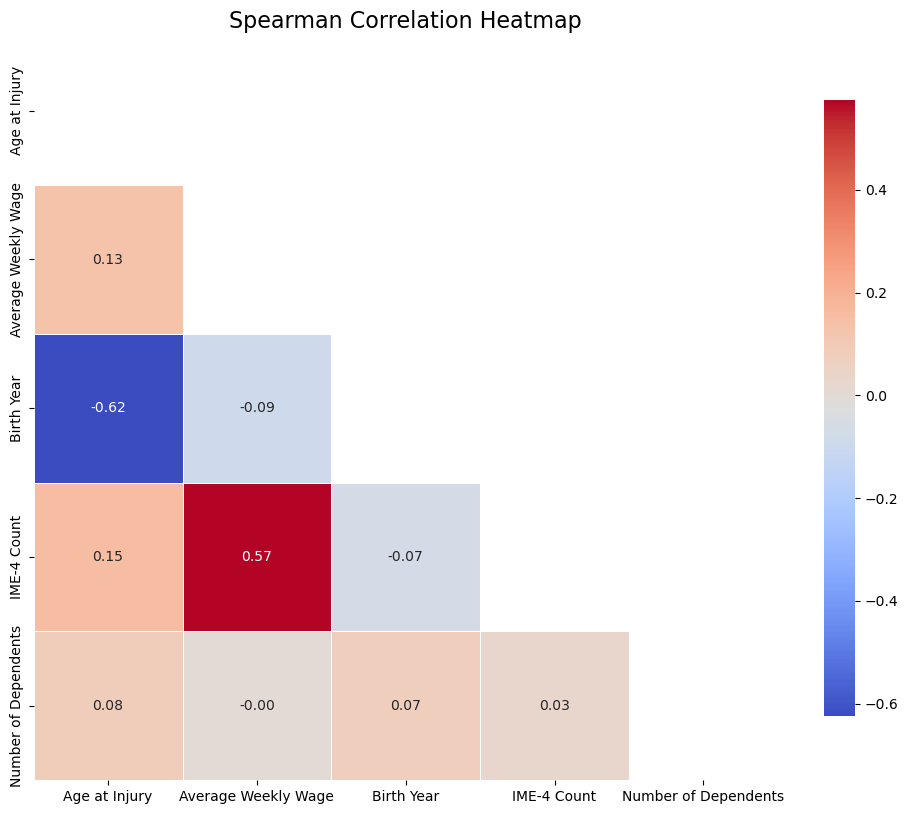

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtain the Spearman correlation matrix
cor_spearman = numeric_features.corr(method="spearman")

# Create a mask for the upper triangle (if you want to hide it)
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define a custom colormap (you can modify the colors as needed)
custom_cmap = sns.color_palette("coolwarm", as_cmap=True)  # Change to your preferred colormap

# Optionally, define whether to annotate or not
annot = True  # Set to True to show the correlation coefficients

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data=cor_spearman, 
             annot=annot, 
             cmap=custom_cmap, 
             mask=mask, 
             fmt='.2f',  # Format for the annotation, use '.2f' for float
             square=True,  # Keep cells square
             linewidths=0.5,  # Add lines between cells for clarity
             cbar_kws={"shrink": .8})  # Adjust the colorbar size

# Add title
plt.title('Spearman Correlation Heatmap', fontsize=16)

# Show the heatmap
plt.show()

## Outliers